In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [112]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

In [113]:
runner.ranking = join.ranking / join.participants

In [114]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)

In [115]:
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]

In [116]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               66222 non-null   float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

<AxesSubplot:xlabel='year', ylabel='count'>

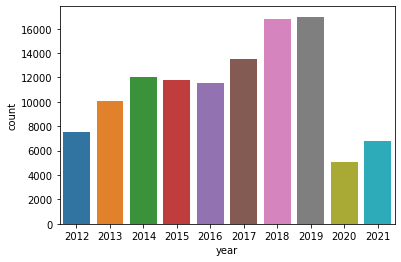

In [117]:
sns.countplot(
    x = 'year',
    data = join
)

## Prédiction de performance pour les coureurs en 2019

In [118]:
def scoring(x):
    return 1/x

In [119]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    print(race_to_predict.iloc[0])
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        has_run = 0
        total_distance = 0
        total_races = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        
        if runner_past.size > 0: 
            has_run = 1
            total_distance =  runner_past.equivalent_distance.sum()
            total_races = runner_past.shape[0]
            for name, values in runner_past['ranking'].iteritems():
                ranking_score += 1/values
               
            last_year_df = runner_past.loc[runner_past.date > date_to_predict - pd.DateOffset(years=1)]
            if len(last_year_df) > 0:
                has_run_last_year = 1
                distance_previous_year = last_year_df.equivalent_distance.sum()
            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'total_distance': total_distance,
                        'distance_previous_year': distance_previous_year,
                        'total_races': total_races,
                        'has_run': has_run,
                        'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score
                       }, ignore_index = True)
    return df

In [120]:
runner_p = runner_profile(join,race, 54013)

race_year_id                          54013
event                           SPARNATRAIL
race                     P'tiot Sparnatrail
country                              France
participation                          solo
distance                               33.3
elevation_gain                        750.0
elevation_loss                       -750.0
aid_stations                              1
participants                           1800
year                                   2019
month                                    11
day                                      10
frequency_in_ranking                    693
equivalent_distance                    40.8
weighted_elevation                 0.183824
date                    2019-11-10 00:00:00
Name: 110, dtype: object


100%|█████████████████████████████████████████| 692/692 [00:08<00:00, 79.22it/s]


In [121]:
runner_p

,runner_id,age,gender,nationality,total_distance,distance_previous_year,total_races,has_run,has_run_last_year,has_run_equivalent_course,avg_course_per_year,ranking_score
0,TIPHENEGuillaumeFRAM27.0,27.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,MAESPaulFRAM34.0,34.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,NADRISamirFRAM25.0,25.0,M,FRA,269.9,0.0,1.0,1.0,0.0,1.0,0.0,10.97561
3,HingrandCorentinFRAM24.0,24.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,FRANCOISFlorentFRAM31.0,31.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
687,BERKIAEmmanuelleFRAW44.0,44.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
688,LEBONSebastienFRAM45.0,45.0,M,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
689,TONDELLIERChouFRAW34.0,34.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
690,GALATEAUJulieFRAW33.0,33.0,W,FRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


<AxesSubplot:xlabel='ranking_score', ylabel='count'>

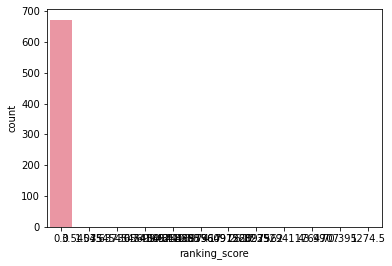

In [122]:
sns.countplot(
    x = runner_p.ranking_score
)